In [1]:
%load_ext autoreload
%autoreload 2
from network import *

In [2]:
# 필요한 라이브러리 불러오기
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(y):
    encoder = OneHotEncoder(sparse=False)
    y_reshaped = y.reshape(-1, 1)
    return encoder.fit_transform(y_reshaped)

# Iris 데이터셋 불러오기
iris = load_digits()
X = iris.data
y = iris.target
y = one_hot_encode(y)
# 데이터셋을 train과 test로 분할 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 결과 출력
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')


Training set size: 1437
Test set size: 360


c:\Users\coex0\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 5.7.3 오차역전파법으로 구한 기울기 검증하기

In [ ]:
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)

In [ ]:
X_batch = X_train[:3]
y_batch = y_train[:3]

grad_numerical = network.numerical_gradient(X_batch, y_batch)
grad_backprop = network.gradient(X_batch, y_batch)

In [ ]:
network.params

In [ ]:
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

## 5.7.4 오차역전파법을 사용한 학습 구현하기

### Using gradient descent

In [ ]:
network = TwoLayerNetwork(X_train[0].size, 200, y_train[0].size)

num_iter = 200
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.03
train_loss_log = []
train_acc_log = []
test_acc_log = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()

5


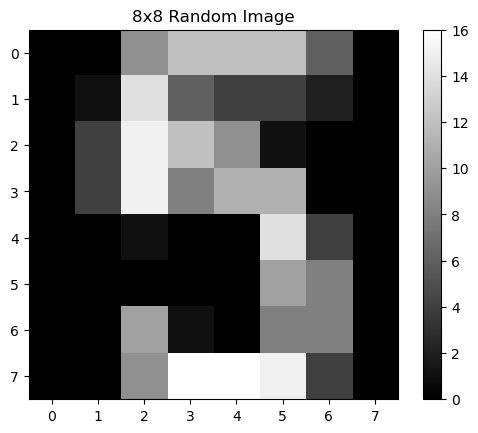

In [31]:
test = X_test[94]
print(network.infer(test))
plt.imshow(test.reshape(8, 8), cmap='gray')  # cmap을 'gray'로 설정하여 흑백 이미지로 표시
plt.colorbar()  # 색상 막대를 추가합니다
plt.title("8x8 Random Image")
plt.show()

In [ ]:
info = {
    "Affain1":(X_train[0].size, 200),
    "ReLU1":(200, 200),
    "Affain2":(200, y_train[0].size),
    "SoftmaxWithLoss":(y_train[0].size, y_train[0].size)
}
network = MultiLayerNetwork(info=info)
network.fit(X_train, y_train, batch_size=100, epoch=200, learning_rate=0.03)

### Using moment

In [ ]:
import copy
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)

num_iter = 1000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.03
alpha = 0.5
moment = copy.deepcopy(network.params)
for key in list(moment.keys()):
    moment[key] *= 0

train_loss_log = []
train_acc_log = []
test_acc_log = []
grad = None
for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
         moment[key] = alpha*moment[key] - learning_rate*grad[key]
         network.params[key] += moment[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()

In [33]:
info = {
    "Affain1":(X_train[0].size, 200),
    "ReLU1":(200, 200),
    "Affain2":(200, y_train[0].size),
    "SoftmaxWithLoss":(y_train[0].size, y_train[0].size)
}
network = MultiLayerNetwork(info=info, optimizer="momentum")
network.fit(X_train, y_train, batch_size=100, epoch=200, learning_rate=0.03, moment_const=0.5)

'final loss : 0.017527877228527958 / final train accuracy : 0.9944328462073765'

### Using learning rate decay

In [ ]:
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)
num_iter = 1000
train_size = X_train.shape[0]
batch_size = 100
initial_learning_rate = 0.05
learning_rate = initial_learning_rate
learning_rate_decay = 0.99  # learning rate decay factor
train_loss_log = []
train_acc_log = []
test_acc_log = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % iter_per_epoch == 0:
        learning_rate *= learning_rate_decay  # decay the learning rate
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()
